In [1]:
import sys
!{sys.executable} -m pip install xgboost
!{sys.executable} -m pip install imblearn

In [2]:
## import all the packages needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

In [3]:
## read NHANES dataset
df = pd.read_csv('/Users/DELL/Desktop/Nhanes_2005_2014.csv')
# check if there are duplicated id, All false --> there is not duplicated id
df.SEQN.duplicated().value_counts()


False    50965
Name: SEQN, dtype: int64

In [4]:
## find all the distinct values of DIQ010
df.DIQ010.value_counts()

2.0    44558
1.0     3482
3.0      653
9.0       33
7.0        3
Name: DIQ010, dtype: int64

In [5]:
## data preparation
# exclude null values and NA
df = df[(df.DIQ010.notnull()) & (df.DIQ010 != 9)& (df.DIQ010 != 7) & (df.DIQ010 != 3)]
# check DIQ010
df.DIQ010.describe()

count    48040.000000
mean         1.927519
std          0.259286
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          2.000000
Name: DIQ010, dtype: float64

In [6]:
# exclude non-numeric values
d = df.select_dtypes(['number'])

# exclude columns that have over 50% NaN
d = d.dropna(thresh = 0.5*len(d), axis =1)

print(len(d.columns), 'columns are left')

252 columns are left


In [7]:
# transform the coding of target variable
d['DIQ010']=d.apply(lambda x: 1 if x.DIQ010 == 1 else 0, axis='columns')
d.DIQ010.value_counts() 


0    44558
1     3482
Name: DIQ010, dtype: int64

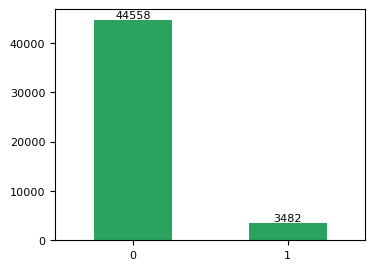

In [8]:
## plot the distribution of values of response variable
vals = d.DIQ010.value_counts()

plt.figure(figsize=(4,3))
plt.rc('font', size=8)

ax = vals.plot.bar(rot=0, color='#2ca25f')
for i in range(len(vals)):
    ax.annotate(vals[i], xy=[vals.index[i], vals[i]], ha='center', va='bottom')

In [9]:
# replace NA with most frequent values
from sklearn.impute import SimpleImputer
sim_imp = SimpleImputer(strategy='most_frequent')

d = pd.DataFrame(sim_imp.fit_transform(d), columns=d.columns)
## show the complete dataset
d 

,SEQN,WTDRD1,WTDR2D,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DAY,DR1LANG,DR1MNRSP,...,DIQ160,DIQ170,DIQ180,DIQ050,DR1DBIH,DR1TVD,INDHHIN2,INDFMIN2,DR2DBIH,DR2TVD
0,31128.0,3.933789e+03,4.250890e+03,1.0,16.0,2.0,2.0,6.0,1.0,1.0,...,2.0,2.0,2.0,2.0,20.0,0.2,15.0,15.0,20.0,0.4
1,31129.0,2.671981e+04,2.671981e+04,1.0,10.0,2.0,2.0,2.0,1.0,1.0,...,2.0,2.0,1.0,2.0,20.0,0.2,15.0,15.0,20.0,0.4
2,31130.0,5.397605e-79,5.397605e-79,5.0,25.0,2.0,2.0,6.0,1.0,1.0,...,2.0,2.0,1.0,2.0,20.0,0.2,15.0,15.0,20.0,0.4
3,31131.0,1.359590e+04,1.482248e+04,1.0,16.0,2.0,2.0,6.0,1.0,1.0,...,2.0,1.0,1.0,2.0,20.0,0.2,15.0,15.0,20.0,0.4
4,31132.0,4.048414e+04,4.566064e+04,1.0,23.0,2.0,2.0,3.0,1.0,1.0,...,2.0,2.0,2.0,2.0,20.0,0.2,15.0,15.0,20.0,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48035,83551.0,5.397605e-79,5.397605e-79,1.0,25.0,2.0,2.0,6.0,1.0,1.0,...,2.0,2.0,2.0,2.0,20.0,0.2,12.0,14.0,20.0,0.4
48036,83593.0,5.397605e-79,5.397605e-79,1.0,25.0,2.0,2.0,6.0,1.0,1.0,...,2.0,2.0,2.0,2.0,20.0,0.2,4.0,4.0,20.0,0.4
48037,83635.0,5.397605e-79,5.397605e-79,1.0,25.0,2.0,2.0,6.0,1.0,1.0,...,2.0,2.0,2.0,2.0,20.0,0.2,1.0,1.0,20.0,0.4
48038,83652.0,5.397605e-79,5.397605e-79,1.0,25.0,2.0,2.0,6.0,1.0,1.0,...,2.0,2.0,1.0,2.0,20.0,0.2,15.0,8.0,20.0,0.4


In [10]:
## separate predictors and responses
X = d.loc[:, d.columns != 'DIQ010']
Y = d.DIQ010
print('X shape:', X.shape)
print('Y shape:', Y.shape)

X shape: (48040, 251)
Y shape: (48040,)


In [11]:
## split the data into training dataset and testing dataset (8:2)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=12)


In [12]:
## Feature selection: XGBClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

model = XGBClassifier()
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

## confusion matrix
def confusion(Y_test, Y_pred):
    conf = pd.DataFrame(confusion_matrix(Y_test, Y_pred), index=['True[0]', 'True[1]'], columns=['Predict[0]', 'Predict[1]'])
    print('Confusion Matrix:')
    print(conf)
    return conf

confusion(Y_test, Y_pred) 


Accuracy: 96.30%
Confusion Matrix:
         Predict[0]  Predict[1]
True[0]       11023         155
True[1]         289         543


,Predict[0],Predict[1]
True[0],11023,155
True[1],289,543


In [13]:
## Oversampling with SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_train_smote, Y_train_smote = smote.fit_resample(X_train, Y_train)
X_test_smote, Y_test_smote = smote.fit_resample(X_test, Y_test)

X_train_smote = pd.DataFrame(X_train_smote, columns=X.columns)
X_test_smote = pd.DataFrame(X_test_smote, columns=X.columns)

## show the dataset after SMOTE
print(Y_train_smote.value_counts())
print(Y_test_smote.value_counts())

0.0    33380
1.0    33380
Name: DIQ010, dtype: int64
0.0    11178
1.0    11178
Name: DIQ010, dtype: int64


In [14]:
# The classification result after SMOTE
model = XGBClassifier()
model.fit(X_train_smote, Y_train_smote)
Y_pred_smote = model.predict(X_test_smote)

accuracy = accuracy_score(Y_test_smote, Y_pred_smote)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
conf = pd.DataFrame(confusion_matrix(Y_test_smote, Y_pred_smote), index=['True[0]', 'True[1]'], columns=['Predict[0]', 'Predict[1]'])
conf

Accuracy: 97.92%


,Predict[0],Predict[1]
True[0],10984,194
True[1],270,10908


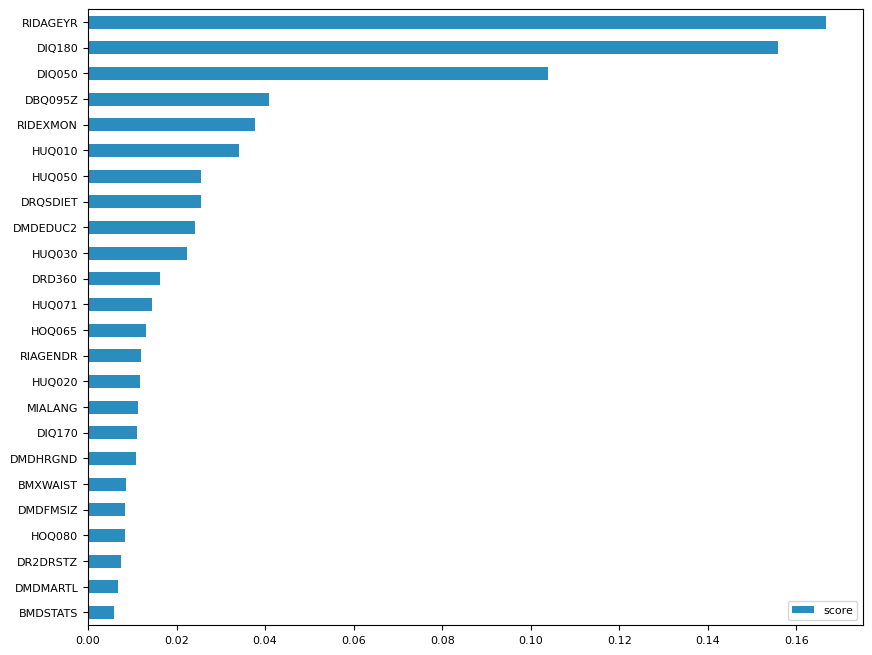

In [15]:
from xgboost import XGBClassifier
from matplotlib import pyplot
import time
st = time.time()

# fit model no training data
model = XGBClassifier()
model.fit(X_train_smote, Y_train_smote)

# Features selected by XGBoost
keys = list(model.get_booster().feature_names)
values = list(model.feature_importances_)

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)

# Top 24 features
xgbfs_ = data[:24]

# Plot feature score
xgbfs_.sort_values(by='score').plot(kind='barh', figsize=(10, 8), color='#2b8cbe')
plt.rc('font', size=8)

In [16]:
xgbfs = xgbfs_.reset_index()
xgbfs.columns=['variable', 'score']

xgbfs['variable'] = xgbfs['variable'].apply(lambda x: x.upper())

In [17]:
## all variables list
var_list = xgbfs.variable.tolist()
var_list.append('DIQ010')
print(var_list)
df_final = d.filter(var_list)
df_final

['RIDAGEYR', 'DIQ180', 'DIQ050', 'DBQ095Z', 'RIDEXMON', 'HUQ010', 'HUQ050', 'DRQSDIET', 'DMDEDUC2', 'HUQ030', 'DRD360', 'HUQ071', 'HOQ065', 'RIAGENDR', 'HUQ020', 'MIALANG', 'DIQ170', 'DMDHRGND', 'BMXWAIST', 'DMDFMSIZ', 'HOQ080', 'DR2DRSTZ', 'DMDMARTL', 'BMDSTATS', 'DIQ010']


,RIDAGEYR,DIQ180,DIQ050,DBQ095Z,RIDEXMON,HUQ010,HUQ050,DRQSDIET,DMDEDUC2,HUQ030,...,MIALANG,DIQ170,DMDHRGND,BMXWAIST,DMDFMSIZ,HOQ080,DR2DRSTZ,DMDMARTL,BMDSTATS,DIQ010
0,11.0,2.0,2.0,1.0,1.0,4.0,2.000000e+00,2.0,4.0,1.0,...,1.0,2.0,1.0,62.8,6.0,2.0,1.0,1.0,1.0,0.0
1,15.0,1.0,2.0,1.0,2.0,3.0,5.397605e-79,2.0,4.0,1.0,...,1.0,2.0,1.0,97.8,6.0,2.0,1.0,5.0,1.0,0.0
2,85.0,1.0,2.0,1.0,2.0,3.0,1.000000e+00,2.0,4.0,2.0,...,1.0,2.0,2.0,96.0,1.0,2.0,5.0,2.0,4.0,0.0
3,44.0,1.0,2.0,4.0,2.0,3.0,5.000000e+00,2.0,4.0,1.0,...,1.0,1.0,1.0,96.0,4.0,2.0,1.0,1.0,3.0,0.0
4,70.0,2.0,2.0,2.0,2.0,2.0,3.000000e+00,2.0,5.0,1.0,...,1.0,2.0,1.0,96.5,2.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48035,28.0,2.0,2.0,1.0,2.0,1.0,2.000000e+00,2.0,5.0,1.0,...,1.0,2.0,2.0,96.0,1.0,2.0,1.0,5.0,1.0,0.0
48036,44.0,2.0,2.0,1.0,2.0,2.0,2.000000e+00,2.0,5.0,1.0,...,1.0,2.0,2.0,96.0,2.0,2.0,1.0,3.0,1.0,0.0
48037,17.0,2.0,2.0,1.0,2.0,3.0,2.000000e+00,2.0,4.0,1.0,...,1.0,2.0,1.0,96.0,7.0,2.0,1.0,1.0,1.0,0.0
48038,39.0,1.0,2.0,1.0,2.0,4.0,2.000000e+00,2.0,5.0,1.0,...,1.0,2.0,2.0,96.0,1.0,2.0,1.0,6.0,1.0,0.0


<AxesSubplot:>

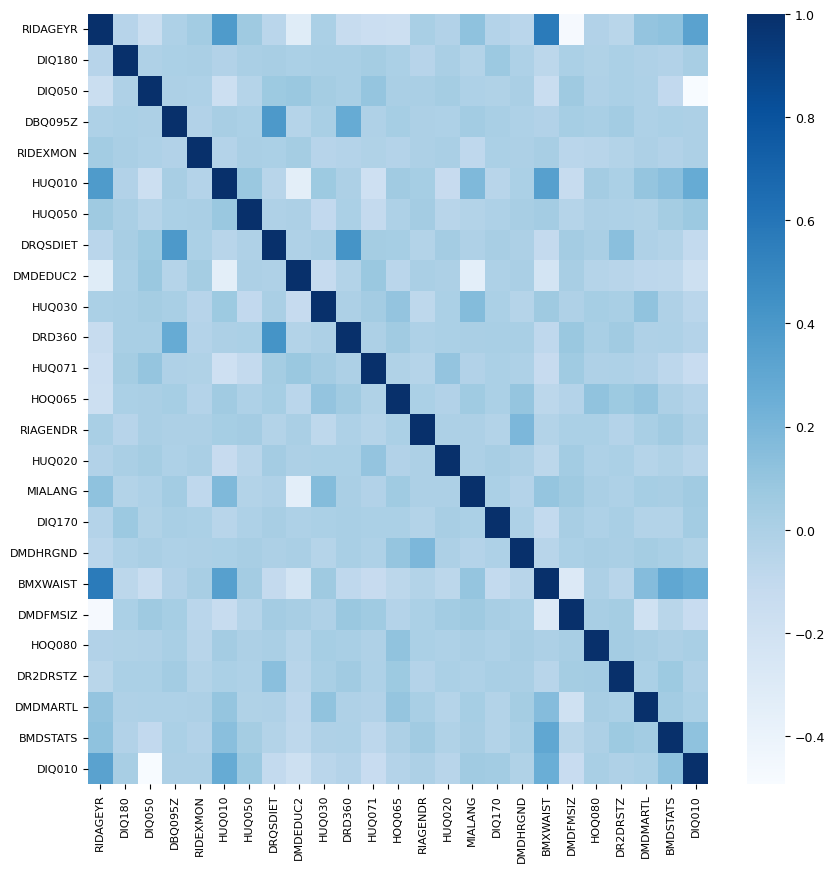

In [18]:
## draw correlation heatmap
ax = plt.subplots(figsize=(10,10))
plt.rc('font', size=9)

corr = df_final.corr()

sns.heatmap(corr, cmap="Blues")

In [19]:
X_ = df_final.loc[:, df_final.columns != 'DIQ010']
Y = df_final.DIQ010

In [20]:
## min-max scaling
from sklearn.preprocessing import MinMaxScaler
minmax=MinMaxScaler()
X = pd.DataFrame(minmax.fit_transform(X_), columns=X_.columns)
X

,RIDAGEYR,DIQ180,DIQ050,DBQ095Z,RIDEXMON,HUQ010,HUQ050,DRQSDIET,DMDEDUC2,HUQ030,...,HUQ020,MIALANG,DIQ170,DMDHRGND,BMXWAIST,DMDFMSIZ,HOQ080,DR2DRSTZ,DMDMARTL,BMDSTATS
0,0.119048,0.125,0.125,0.000000,0.0,0.375,0.020202,0.125,0.375,0.000,...,0.25,0.0,0.125,0.0,0.177054,0.833333,0.125,0.0,0.000000,0.000000
1,0.166667,0.000,0.125,0.000000,1.0,0.250,0.000000,0.125,0.375,0.000,...,0.25,0.0,0.125,0.0,0.424929,0.833333,0.125,0.0,0.040816,0.000000
2,1.000000,0.000,0.125,0.000000,1.0,0.250,0.010101,0.125,0.375,0.125,...,0.25,0.0,0.125,1.0,0.412181,0.000000,0.125,1.0,0.010204,1.000000
3,0.511905,0.000,0.125,0.030612,1.0,0.250,0.050505,0.125,0.375,0.000,...,0.00,0.0,0.000,0.0,0.412181,0.500000,0.125,0.0,0.000000,0.666667
4,0.821429,0.125,0.125,0.010204,1.0,0.125,0.030303,0.125,0.500,0.000,...,0.25,0.0,0.125,0.0,0.415722,0.166667,0.000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48035,0.321429,0.125,0.125,0.000000,1.0,0.000,0.020202,0.125,0.500,0.000,...,0.25,0.0,0.125,1.0,0.412181,0.000000,0.125,0.0,0.040816,0.000000
48036,0.511905,0.125,0.125,0.000000,1.0,0.125,0.020202,0.125,0.500,0.000,...,0.25,0.0,0.125,1.0,0.412181,0.166667,0.125,0.0,0.020408,0.000000
48037,0.190476,0.125,0.125,0.000000,1.0,0.250,0.020202,0.125,0.375,0.000,...,0.25,0.0,0.125,0.0,0.412181,1.000000,0.125,0.0,0.000000,0.000000
48038,0.452381,0.000,0.125,0.000000,1.0,0.375,0.020202,0.125,0.500,0.000,...,0.00,0.0,0.125,1.0,0.412181,0.000000,0.125,0.0,0.051020,0.000000


In [21]:
## Create an empty list containing the accuracy scores of the models
mscore=[]

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=12)

X_train_smote, Y_train_smote = smote.fit_resample(X_train, Y_train)
X_test_smote, Y_test_smote = smote.fit_resample(X_test, Y_test)

X_train_smote = pd.DataFrame(X_train_smote, columns=X.columns)
X_test_smote = pd.DataFrame(X_test_smote, columns=X.columns)

In [23]:
## Logistic Regression
from sklearn.linear_model import LogisticRegression
import time

clf = LogisticRegression(max_iter=100, solver='lbfgs', class_weight='balanced', random_state=11)

## time of running
tic = time.time()
clf.fit(X_train_smote, Y_train_smote)
toc = time.time()
print("Time: " + str(1000*(toc-tic)) + "ms")

clf_prediction_proba = clf.predict_proba(X_test)[:, 1]

## make predictions
Y_pred = clf.predict(X_test)
print('Accuracy Score:', clf.score(X_test, Y_test))
print('Prediction:', Y_pred)

## append the score to the list
mscore.append(['Logistic Regression', clf.score(X_test, Y_test)])

print(classification_report(Y_test, Y_pred))
confusion(Y_test, Y_pred)

Time: 1356.1699390411377ms
Accuracy Score: 0.8408825978351374
Prediction: [0. 0. 0. ... 0. 0. 0.]
              precision    recall  f1-score   support

         0.0       0.99      0.84      0.91     11178
         1.0       0.29      0.87      0.43       832

    accuracy                           0.84     12010
   macro avg       0.64      0.85      0.67     12010
weighted avg       0.94      0.84      0.87     12010

Confusion Matrix:
         Predict[0]  Predict[1]
True[0]        9379        1799
True[1]         112         720


D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Predict[0],Predict[1]
True[0],9379,1799
True[1],112,720


In [24]:
## random forest model
from sklearn.ensemble import RandomForestClassifier
import time

rnd_clf = RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=5, 
                                 min_samples_split = 2, min_samples_leaf = 1, random_state=11)

## time of running
tic = time.time()
model = rnd_clf.fit(X_train_smote, Y_train_smote)
toc = time.time()
print("Time: " + str(1000*(toc-tic)) + "ms")
rf_prediction_proba = rnd_clf.predict_proba(X_test)[:, 1]

## make predictions
y_pred = rnd_clf.predict(X_test)

print('Accuracy Score:', rnd_clf.score(X_test, Y_test))
print('Prediction:', Y_pred)

## append the score to the list
mscore.append(['Random Forest', rnd_clf.score(X_test, Y_test)])

print(classification_report(Y_test, Y_pred))
confusion(Y_test, Y_pred)

## print importance tree random forest
print(pd.DataFrame({'Variable':X.columns,
              'Importance':model.feature_importances_}).sort_values('Importance', ascending=False))

Time: 9584.123611450195ms
Accuracy Score: 0.9294754371357202
Prediction: [0. 0. 0. ... 0. 0. 0.]
              precision    recall  f1-score   support

         0.0       0.99      0.84      0.91     11178
         1.0       0.29      0.87      0.43       832

    accuracy                           0.84     12010
   macro avg       0.64      0.85      0.67     12010
weighted avg       0.94      0.84      0.87     12010

Confusion Matrix:
         Predict[0]  Predict[1]
True[0]        9379        1799
True[1]         112         720
    Variable  Importance
0   RIDAGEYR    0.211249
5     HUQ010    0.146199
2     DIQ050    0.129753
1     DIQ180    0.120831
18  BMXWAIST    0.104661
6     HUQ050    0.067394
7   DRQSDIET    0.066164
8   DMDEDUC2    0.036878
19  DMDFMSIZ    0.022889
11    HUQ071    0.017108
3    DBQ095Z    0.015379
10    DRD360    0.014432
22  DMDMARTL    0.014221
9     HUQ030    0.010183
16    DIQ170    0.009680
12    HOQ065    0.005956
14    HUQ020    0.004071
20    HOQ080

In [25]:
## gradient boosting
from sklearn.ensemble import GradientBoostingClassifier
import time

gbc = GradientBoostingClassifier(learning_rate=0.1, n_estimators=10, random_state=11)

## time of running
tic = time.time()
gbc.fit(X_train_smote, Y_train_smote)
toc = time.time()
print("Time: " + str(1000*(toc-tic)) + "ms")
gbc_prediction_proba = gbc.predict_proba(X_test)[:, 1]

## make predictions
Y_pred = gbc.predict(X_test)

print('Accuracy Score:', gbc.score(X_test, Y_test))
print('Prediction:', Y_pred)

## append the score to the list
mscore.append(['GradientBoosting', gbc.score(X_test, Y_test)])

print(classification_report(Y_test, Y_pred))
confusion(Y_test, Y_pred)

Time: 2033.1480503082275ms
Accuracy Score: 0.8893422148209825
Prediction: [0. 0. 0. ... 1. 0. 0.]
              precision    recall  f1-score   support

         0.0       0.99      0.89      0.94     11178
         1.0       0.38      0.92      0.54       832

    accuracy                           0.89     12010
   macro avg       0.69      0.90      0.74     12010
weighted avg       0.95      0.89      0.91     12010

Confusion Matrix:
         Predict[0]  Predict[1]
True[0]        9914        1264
True[1]          65         767


,Predict[0],Predict[1]
True[0],9914,1264
True[1],65,767


In [26]:
## Support Vector Machine
from sklearn.svm import SVC
import time

svm_clf = SVC(kernel='sigmoid', gamma='auto', random_state=11)

## time of running
tic = time.time()
svm_clf.fit(X_train_smote, Y_train_smote)
toc = time.time()
print("Time: " + str(1000*(toc-tic)) + "ms")

Y_pred = svm_clf.predict(X_test)

print('Accuracy Score:', svm_clf.score(X_test, Y_test))
print('Prediction:', Y_pred)

mscore.append(['SVM', svm_clf.score(X_test, Y_test)])

# from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred))
confusion(Y_test, Y_pred)

Time: 204397.92704582214ms
Accuracy Score: 0.805578684429642
Prediction: [0. 0. 0. ... 1. 0. 0.]
              precision    recall  f1-score   support

         0.0       0.99      0.80      0.88     11178
         1.0       0.25      0.91      0.39       832

    accuracy                           0.81     12010
   macro avg       0.62      0.85      0.64     12010
weighted avg       0.94      0.81      0.85     12010

Confusion Matrix:
         Predict[0]  Predict[1]
True[0]        8920        2258
True[1]          77         755


,Predict[0],Predict[1]
True[0],8920,2258
True[1],77,755


In [27]:
## Bagging K-Nearest Neighbors
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
import time

bagging = BaggingClassifier(base_estimator= KNeighborsClassifier(), max_samples = 0.5, max_features = 0.5, 
                            bootstrap = False, bootstrap_features = False, random_state=11)
## time of running
tic = time.time()
bagging.fit(X_train_smote, Y_train_smote)
toc = time.time()
print("Time: " + str(1000*(toc-tic)) + "ms")

kn_prediction_proba = bagging.predict_proba(X_test)[:, 1]

## make predictions
bg_pred_diabetes = bagging.predict(X_test)

print('Accuracy Score:', bagging.score(X_test, Y_test))
print('Prediction:', Y_pred)

bg_score = bagging.score(X_test, Y_test)
bagging.score(X_test, Y_test)

## append the score to the list
mscore.append(['Bagging_KNeighbors', bagging.score(X_test, Y_test)])

Time: 1670.1109409332275ms
Accuracy Score: 0.9109075770191507
Prediction: [0. 0. 0. ... 1. 0. 0.]


In [28]:
## MLP
from sklearn.neural_network import MLPClassifier
import time

mlp = MLPClassifier(hidden_layer_sizes=(100,100), solver='adam', shuffle=False, tol = 0.0001, random_state=11)

## time of running
tic = time.time()
mlp.fit(X_train_smote, Y_train_smote)
toc = time.time()
print("Time:" + str(1000*(toc-tic)) + "ms")

mlp_prediction_proba = mlp.predict_proba(X_test)[:, 1]

## make predictions
mlp_pred_diabetes = mlp.predict(X_test)
print('Accuracy Score:', mlp.score(X_test, Y_test))
print('Prediction:', mlp_pred_diabetes)

## see the parameters ready to be adjusted
print("parameter: ", mlp.get_params())

## append the score to the list
mscore.append(['MLP', mlp.score(X_test, Y_test)])

Time:10753.110647201538ms
Accuracy Score: 0.3951706910907577
Prediction: [0. 1. 1. ... 1. 1. 1.]
parameter:  {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 11, 'shuffle': False, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


In [29]:
## Bagging Decision Tree
from sklearn.tree import DecisionTreeClassifier
import time

bagging = BaggingClassifier(base_estimator= DecisionTreeClassifier(), max_samples = 0.5, max_features = 0.5, 
                            bootstrap = False, bootstrap_features = False, random_state=11)

## time of running
tic = time.time()
bagging.fit(X_train_smote, Y_train_smote)
toc = time.time()
print("Time:" + str(1000*(toc-tic)) + "ms")

bdt_prediction_proba = bagging.predict_proba(X_test)[:, 1]

## make predictions
bg_pred_diabetes = bagging.predict(X_test)
print('Accuracy Score:', bagging.score(X_test, Y_test))
print('Prediction:', Y_pred)

bg_dt_score = bagging.score(X_test, Y_test)
bagging.score(X_test, Y_test)

## append the score to the list
mscore.append(['Bagging_Decision Tree based', bagging.score(X_test, Y_test)])

Time:1670.14741897583ms
Accuracy Score: 0.9428809325562032
Prediction: [0. 0. 0. ... 1. 0. 0.]


In [30]:
mscore.sort(key=lambda x: x[1], reverse=True)
mscore

[['Bagging_Decision Tree based', 0.9428809325562032],
 ['Random Forest', 0.9294754371357202],
 ['Bagging_KNeighbors', 0.9109075770191507],
 ['GradientBoosting', 0.8893422148209825],
 ['Logistic Regression', 0.8408825978351374],
 ['SVM', 0.805578684429642],
 ['MLP', 0.3951706910907577]]

Accuracy Score: 

Bagging_Decision Tree based: 94.29%
Random Forest: 92.95%
Bagging_KNeighbors: 91.09%
GradientBoosting: 88.93%
Logistic Regression: 84.09%
SVM: 80.56%
MLP: 39.52%


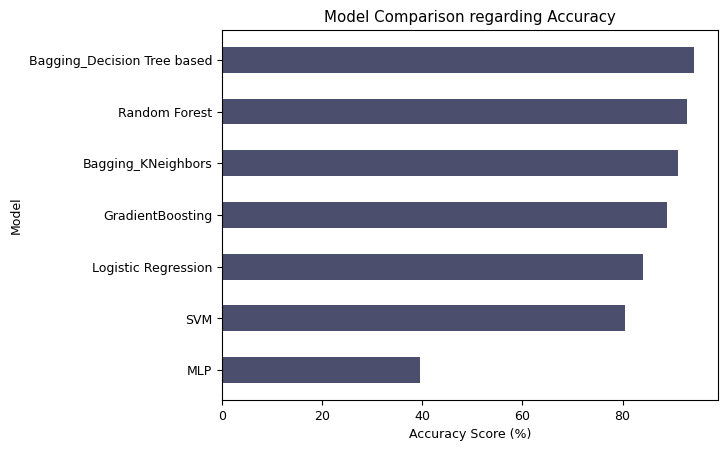

In [31]:
model = list(i[0] for i in mscore)
score = list(round(i[1]*100,2) for i in mscore)

print('Accuracy Score: \n')
for m,s in zip(model, score):
    print(f'{m}: {s}%')

# creating horizontal bar
plt.barh(model, score, height = 0.5, color='#4B4E6D')

plt.xlabel("Accuracy Score (%)")
plt.ylabel("Model")
plt.title("Model Comparison regarding Accuracy")
plt.gca().invert_yaxis()
plt.rc('font', size=9)
plt.show()

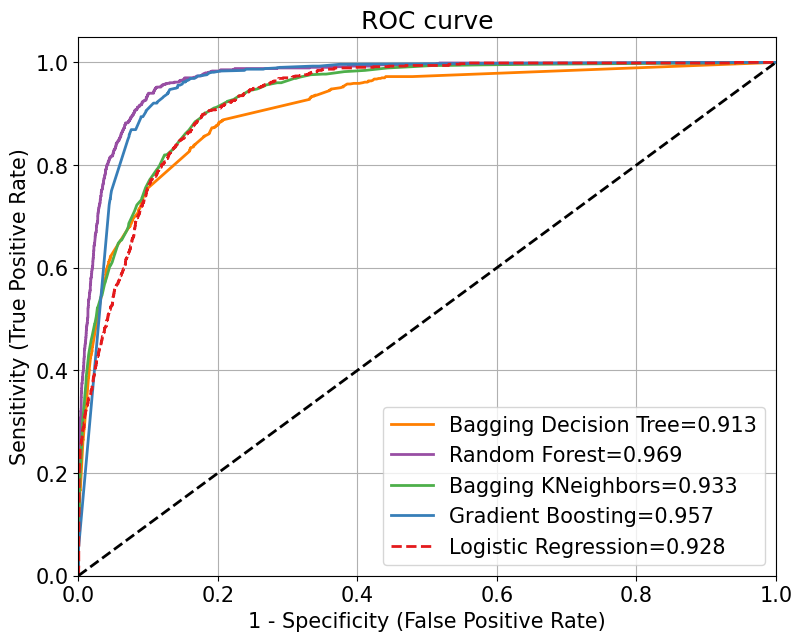

In [32]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 7))
matplotlib.rcParams.update({'font.size': 15})
plt.grid()

def roc_curve_and_score(y_test, pred_proba):
    fpr, tpr, _ = roc_curve(y_test.ravel(), pred_proba.ravel())
    roc_auc = roc_auc_score(y_test.ravel(), pred_proba.ravel())
    return fpr, tpr, roc_auc

## ROC curve
### Bagging Decision Tree
fpr, tpr, roc_auc = roc_curve_and_score(Y_test, bdt_prediction_proba)
plt.plot(fpr, tpr, color='#ff7f00', lw=2,
         label='Bagging Decision Tree={0:.3f}'.format(roc_auc))
### Random Forest
fpr, tpr, roc_auc = roc_curve_and_score(Y_test, rf_prediction_proba)
plt.plot(fpr, tpr, color='#984ea3', lw=2,
         label='Random Forest={0:.3f}'.format(roc_auc))
### Bagging KNeighbors
fpr, tpr, roc_auc = roc_curve_and_score(Y_test, kn_prediction_proba)
plt.plot(fpr, tpr, color='#4daf4a', lw=2,
         label='Bagging KNeighbors={0:.3f}'.format(roc_auc))
### Gradient Boosting
fpr, tpr, roc_auc = roc_curve_and_score(Y_test, gbc_prediction_proba)
plt.plot(fpr, tpr, color='#377eb8', lw=2,
         label='Gradient Boosting={0:.3f}'.format(roc_auc))
### Logistic Regression
fpr, tpr, roc_auc = roc_curve_and_score(Y_test, clf_prediction_proba)
plt.plot(fpr, tpr, color='#e41a1c', lw=2, linestyle='--',
         label='Logistic Regression={0:.3f}'.format(roc_auc))

## reference line (diagonal)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')

## add legends, labels, and plot the ROC curves
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity (False Positive Rate)')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.title("ROC curve")
plt.rc('font', size=9)
plt.show()